<a href="https://colab.research.google.com/github/rickiepark/llm-from-scratch/blob/main/ch07/01_main-chapter-code/ch07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
세바스찬 라시카(Sebastian Raschka)가 쓴 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a>의 번역서 <br><<b><a href="<a href="http://tensorflow.blog/llm-from-scratch">밑바닥부터 만들면서 배우는 LLM</a></b>>의 예제 코드입니다.<br>
<br>코드 저장소: <a href="https://github.com/rickiepark/llm-from-scratch">https://github.com/rickiepark/llm-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://tensorflow.blog/llm-from-scratch"><img src="https://tensorflowkorea.wordpress.com/wp-content/uploads/2025/09/ebb091ebb094eb8ba5llm_ebb3b8ecb185_ec959eeba9b4.jpg" width="100px"></a>
</td>
</tr>
</table>

# 7장: 지시를 따르도록 미세 튜닝하기


In [1]:
from importlib.metadata import version

pkgs = [
    "numpy",       # 파이토치와 텐서플로 의존성
    "matplotlib",  # 그래프 라이브러리
    "tiktoken",    # 토크나이저
    "torch",       # 딥러닝 라이브러리
    "tqdm",        # 진행 표시줄
    "tensorflow",  # OpenAI에서 사전 훈련된 가중치를 로드하기 위해
]
for p in pkgs:
    print(f"{p} 버전: {version(p)}")

numpy 버전: 2.0.2
matplotlib 버전: 3.10.0
tiktoken 버전: 0.12.0
torch 버전: 2.8.0+cu126
tqdm 버전: 4.67.1
tensorflow 버전: 2.19.0


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/01.webp" width=800px>


## 7.1 지시 미세 튜닝 소개


- 5장에서, 우리는 LLM 사전 훈련이 한 번에 한 단어씩 생성하는 것을 배우는 것임을 보았습니다.
- 따라서 사전 훈련된 LLM은 텍스트 완성에는 능숙하지만 지시 사항을 따르는 데는 능숙하지 않습니다.
- 이 장에서는 LLM이 지시 사항을 더 잘 따르도록 가르칩니다.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/02.webp" width=600px>


- 이 장에서 다루는 주제는 아래 그림에 요약되어 있습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/03.webp" width=700px>


## 7.2 지도 학습 미세 튜닝을 위한 데이터셋 준비하기


- 이 장을 위해 준비한 지시 데이터셋을 사용합니다.


In [2]:
import json
import os
import requests


def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text_data = response.text
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data

# 책에서는 다음 코드를 사용했지만 VPN을 사용하는 경우 urllib가 문제를 일으킬 수 있습니다.
# 따라서 더 안정적인 `requests` 패키지를 사용합니다.

"""
import urllib

def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data
"""


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("샘플 개수:", len(data))

샘플 개수: 1100


- 위 JSON 파일에서 로드한 `data` 리스트의 각 항목은 다음 형식의 딕셔너리입니다.


In [3]:
print("샘플 예시:\n", data[50])

샘플 예시:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


- `'input'` 필드는 비어 있을 수 있습니다.


In [4]:
print("다른 샘플:\n", data[999])

다른 샘플:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


- 지시 미세 튜닝은 입력-출력 쌍이 명시적으로 제공되는 데이터셋에서 모델을 학습시키기 때문에 종종 "지도 학습 지시 미세 튜닝"이라고 합니다.
- LLM에 입력으로 항목을 포맷하는 다양한 방법이 있습니다. 아래 그림은 각각 알파카(https://crfm.stanford.edu/2023/03/13/alpaca.html) 및 Phi-3(https://arxiv.org/abs/2404.14219) LLM 훈련에 사용된 두 가지 예시 형식을 보여줍니다.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/04.webp" width=800px>


- 이 장에서는 지시 미세 튜닝을 위한 초기 프롬프트 템플릿인 알파카 스타일 프롬프트 형식을 사용합니다.
- 아래에서는 LLM에 입력으로 전달할 입력을 포맷팅합니다.


In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- 입력 필드가 있는 경우의 출력은 아래와 같습니다.


In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


- 입력 필드가 없는 경우는 다음과 같습니다.


In [7]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


- 마지막으로 다음 절에서 파이토치 데이터 로더를 준비하기 전에 데이터 세트를 훈련, 검증 및 테스트 세트로 나눕니다.


In [8]:
train_portion = int(len(data) * 0.85)  # 훈련을 위한 85%
test_portion = int(len(data) * 0.1)    # 테스트를 위한 10%
val_portion = len(data) - train_portion - test_portion  # 나머지 5%는 검증용

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [9]:
print("훈련 세트 길이:", len(train_data))
print("검증 세트 길이:", len(val_data))
print("테스트 세트 길이:", len(test_data))

훈련 세트 길이: 935
검증 세트 길이: 55
테스트 세트 길이: 110


## 7.3 훈련 배치 만들기


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/05.webp" width=700px>


- 다음 그림에 요약된 것처럼 여러 단계로 이 데이터셋 배치를 처리합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/06.webp" width=700px>


- 먼저, 6장의 `SpamDataset`과 유사하게 데이터셋의 모든 입력을 토큰화하는 `InstructionDataset` 클래스를 구현합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/07.webp" width=800px>


In [10]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # 텍스트 토큰화
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

- 6장과 유사하게, 훈련 속도를 높이기 위해 배치 단위로 여러 훈련 샘플을 묶습니다. 이를 위해서는 모든 입력을 비슷한 길이로 패딩해야 합니다.
- 또한 이전 장과 마찬가지로 `<|endoftext|>` 토큰을 패딩 토큰으로 사용합니다.


In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- 6장에서는 데이터셋의 모든 샘플을 같은 길이로 패딩했습니다.
  - 여기서는 더 정교한 접근 방식을 취하고 데이터 로더에 전달할 수 있는 사용자 지정 콜레이트 함수를 개발합니다.
  - 이 사용자 지정 콜레이트 함수는 각 배치의 훈련 샘플을 동일한 길이로 패딩합니다(단, 배치마다 길이가 다를 수 있음).


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/08.webp" width=800px>


In [12]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # 배치에서 가장 긴 시퀀스 찾기
    # 그리고 최대 길이를 +1씩 증가시켜 아래에서 패딩 토큰을 하나 추가합니다.
    batch_max_length = max(len(item)+1 for item in batch)

    # 입력 패딩 및 준비
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # <|endoftext|> 토큰 추가
        new_item += [pad_token_id]
        # batch_max_length까지 시퀀스 패딩
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # padded[:-1]를 통해 batch_max_length의 +1 설정을 통해 추가된
        # 추가 패딩 토큰을 제거합니다.
        # (추가 패딩 토큰은 이후 코드에서 관련이 있습니다)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # 입력 리스트를 텐서로 변환하고 타깃 장치로 전송
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/09.webp" width=700px>


- 위에서는 LLM에 대한 입력만 반환했습니다. 그러나 LLM 훈련을 위해서는 타깃 값도 필요합니다.
- LLM 사전 훈련과 유사하게, 타깃은 입력을 오른쪽으로 1 위치씩 이동한 것이므로 LLM은 다음 토큰을 예측하는 방법을 학습할 수 있습니다.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/10.webp" width=600px>


In [14]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # 배치에서 가장 긴 시퀀스 찾기
    batch_max_length = max(len(item)+1 for item in batch)

    # 입력 및 타깃 준비
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # <|endoftext|> 토큰 추가
        new_item += [pad_token_id]
        # 시퀀스를 max_length까지 패딩
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # 입력을 위해 마지막 토큰 자르기
        targets = torch.tensor(padded[1:])  # 타깃을 위해 오른쪽으로 +1 이동
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # 입력 리스트를 텐서로 변환하고 타깃 장치로 전송
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [15]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


- 다음으로, 모든 패딩 토큰 ID를 `ignore_index`에 지정한 값으로 바꿉니다. 이 `ignore_index`의 목적은 손실 함수에서 패딩 값을 무시할 수 있도록 하는 것입니다(자세한 내용은 나중에 설명).

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/11.webp" width=700px>

- 구체적으로, 아래 그림과 같이 `50256`에 해당하는 토큰 ID를 `-100`으로 바꿉니다.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/12.webp" width=800px>


- (또한, 샘플의 길이를 제한하고 싶은 경우를 위해 `allowed_max_length`를 사용했습니다. GPT-2 모델에서 지원하는 1024 토큰 문맥 크기보다 긴 데이터셋으로 작업하려는 경우 유용합니다.)


In [16]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # 배치에서 가장 긴 시퀀스 찾기
    batch_max_length = max(len(item)+1 for item in batch)

    # 입력과 타깃 패딩 및 준비
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # <|endoftext|> 토큰 추가
        new_item += [pad_token_id]
        # 시퀀스를 max_length까지 패딩
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # 입력을 위해 마지막 토큰 자르기
        targets = torch.tensor(padded[1:])  # 목표를 위해 오른쪽으로 +1 이동

        # 새로 추가: 목표에서 첫 번째 패딩 토큰을 제외한 모든 토큰을 ignore_index로 바꾸기
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # 새로 추가: 최대 시퀀스 길이로 자르기 (선택 사항)
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # 입력 및 타깃 리스트를 텐서로 변환하고 타깃 장치로 전송
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [17]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


- -100으로 대체하면 어떻게 되는지 살펴보겠습니다.
- 설명을 위해 6장과 유사하게 클래스 레이블이 0과 1인 2개의 작은 분류 작업이 있다고 가정해 보겠습니다.
- 다음과 같은 로짓 값(모델 마지막 층의 출력)이 있는 경우 다음과 같은 손실을 계산합니다.


In [18]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 첫 번째 훈련 샘플
     [-0.5, 1.5]]  # 두 번째 훈련 샘플
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


- 이제, 예상대로 하나의 훈련 샘플을 더 추가하면 손실에 영향을 미칩니다.


In [19]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # 새로운 세 번째 훈련 샘플
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


- 한 샘플의 클래스 레이블을 -100으로 바꾸면 어떻게 되는지 봅시다.


In [20]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- 여기서 볼 수 있듯이, 3개의 훈련 샘플에 대한 손실은 2개의 훈련 샘플에서 계산한 손실과 동일합니다. 이는 크로스 엔트로피 손실 함수가 -100 레이블이 있는 훈련 샘플을 무시했음을 의미합니다.
- 기본적으로 파이토치는 레이블 -100에 해당하는 샘플을 무시하도록 `cross_entropy(..., ignore_index=-100)` 설정을 사용합니다.
- -100인 `ignore_index`를 사용하여 훈련 샘플을 동일한 길이로 채우는 데 사용했던 배치의 추가적인 텍스트 끝(패딩) 토큰을 무시할 수 있습니다.
- 그러나 텍스트 끝(패딩) 토큰(50256)의 첫 번째는 LLM에 응답이 완료되었음을 알리는 데 도움이 될 수 있으므로 무시하고 싶지 않습니다.


- 실제로 아래 그림과 같이 지시 사항에 해당하는 대상 토큰 ID를 마스킹하는 것이 일반적입니다(이 장을 끝낸 독자를 위해 연습문제 남겨 놓겠습니다).


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/13.webp" width=800px>


## 7.4 지시 데이터셋을 위한 데이터 로더 만들기


- 이 절에서는 `InstructionDataset` 클래스와 `custom_collate_fn` 함수를 사용하여 훈련, 검증 및 테스트 데이터 로더를 만듭니다.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/14.webp" width=700px>


- 이전 `custom_collate_fn` 함수의 또 다른 추가 세부 사항은 메인 학습 루프에서 데이터를 처리하지 않고 타깃 장치(예: GPU)로 직접 이동한다는 것입니다. `custom_collate_fn`을 데이터 로더의 일부로 사용할 때 백그라운드 프로세스로 수행할 수 있으므로 효율성이 향상됩니다.
- 파이썬의 표준 라이브러리 `functools`의 `partial` 함수를 사용하여 원본 함수에서 `device` 매개변수가 미리 채워진 새 함수를 만듭니다.


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 참고:
# 다음 줄의 주석을 제거하면 코드가 애플 실리콘 칩에서 실행될 수 있습니다.
# 애플 CPU보다 훨씬 빠릅니다(M3 맥북 에어에서 측정한 결과).
# 하지만 결과 손실 값이 약간 다를 수 있습니다.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

print("장치:", device)

장치: cuda


In [22]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

- 다음으로, 이전 장과 유사하게 데이터 로더의 인스턴스를 만들지만 이제는 배치 처리를 위해 자체 콜레이트 함수를 전달합니다.


In [23]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [24]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- 만들어진 입력 및 타깃 배치의 차원이 어떻게 되는지 살펴보겠습니다.


In [25]:
print("훈련 데이터 로더:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

훈련 데이터 로더:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.Siz

- 위 출력 결과에서 볼 수 있듯이, 모든 배치의 크기는 8이지만 예상대로 길이는 다릅니다.
- `inputs` 배치의 첫 번째 훈련 샘플을 출력하여 입력에 토큰 ID 50256에 해당하는 `<|endoftext|>` 패딩 토큰이 포함되어 있는지 다시 한번 확인해 보겠습니다.


In [26]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


- 마찬가지로, 타깃에 플레이스홀더인 -100 토큰이 포함되어 있는지 다시 확인합니다.


In [27]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


## 7.5 사전 훈련된 LLM 로드하기


- 이 절에서는 5장 5.5절과 6장 6.4절에서 사용했던 것과 동일한 코드를 사용하여 사전 훈련된 GPT 모델을 로드합니다.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/15.webp" width=700px>


- 하지만 1억 2,400만 개의 파라미터를 가진 가장 작은 모델을 로드하는 대신, 3억 5,500만 개의 파라미터를 가진 중간 버전을 로드합니다. 1억 2,400만 개의 파라미터 모델은 지시 미세 튜닝을 통해 합리적인 품질을 얻기에는 너무 작기 때문입니다.


In [28]:
# 코랩의 경우 gpt_download.py와 previous_chapter.py 파일을 다운로드합니다.
!wget https://bit.ly/3FQ2wXM -O gpt_download.py
!wget https://bit.ly/4egJDdd -O previous_chapters.py

--2025-11-10 06:28:18--  https://bit.ly/3FQ2wXM
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/rickiepark/llm-from-scratch/refs/heads/main/ch07/01_main-chapter-code/gpt_download.py [following]
--2025-11-10 06:28:18--  https://raw.githubusercontent.com/rickiepark/llm-from-scratch/refs/heads/main/ch07/01_main-chapter-code/gpt_download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4687 (4.6K) [text/plain]
Saving to: ‘gpt_download.py’

gpt_download.py     100%[===================>]   4.58K  --.-KB/s    in 0s      

2025-11-10 06:28:18 (50.0 MB/s) - ‘gpt_download.py’ saved [4687/46

In [29]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # 어휘사전 크기
    "context_length": 1024,  # 문맥 길이
    "drop_rate": 0.0,        # 드롭아웃 비율
    "qkv_bias": True         # 쿼리-키-값 편향
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 252kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 713kiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 207kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [12:45<00:00, 1.85MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 12.6MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 498kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 362kiB/s]


- 다음 절에서 모델 미세 튜닝을 시작하기 전에 유효성 검사 작업의 하나로 모델의 성능을 살펴보겠습니다.


In [30]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [31]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)


token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

- 이전 장에서 사용했던 `generate` 함수는 입력과 출력 텍스트를 결합하여 반환합니다. 이는 이전 절에서 읽기 쉬운 텍스트를 생성하는 데 편리했습니다.
- 응답을 분리하기 위해 `generated_text`의 시작 부분에서 지시의 길이를 뺄 수 있습니다.


In [32]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


- 모델이 아직 지시를 따르지 못하는 것을 볼 수 있습니다. "Response" 섹션을 만들지만 원래 입력 문장과 지시를 그대로 반복합니다.


## 7.6 지시 데이터에서 LLM 미세 튜닝하기


- 이 절에서는 모델을 미세 튜닝합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/16.webp" width=800px>

- 이전 장에서 사용했던 손실 계산 및 학습 함수를 모두 재사용할 수 있습니다.


In [33]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

- 훈련을 시작하기 전에 초기 훈련 및 검증 세트 손실을 계산해 보겠습니다(이전 장에서와 같이 목표는 손실을 최소화하는 것입니다).


In [34]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("훈련 손실:", train_loss)
print("검증 손실:", val_loss)

훈련 손실: 3.825909376144409
검증 손실: 3.7619347095489504


- 이전 장보다 더 큰 모델(1억 2,400만 개가 아닌 3억 5,500만 개의 매개변수)을 사용하기 때문에 훈련에 드는 비용이 약간 더 높다는 점에 유의하세요.
- 다양한 기기의 실행 시간은 아래 표를 참고하세요(호환되는 GPU 기기에서 이 노트북을 실행하는 데 코드를 변경할 필요가 없습니다).


<div style="text-align: left;">
    
| 모델              | 기기                | 2 에포크 실행 시간 |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78분        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77분        |
| gpt2-medium (355M) | GPU (L4)              | 1.83분         |
| gpt2-medium (355M) | GPU (A100)            | 0.86분         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74분         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73분         |
| gpt2-small (124M)  | GPU (L4)              | 0.69분         |
| gpt2-small (124M)  | GPU (A100)            | 0.39분         |

</div>

- 이 노트북은 `"gpt2-medium (355M)"` 모델을 사용하여 실행했습니다.


In [35]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"훈련 소요 시간: {execution_time_minutes:.2f}분")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.533, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.568, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.604, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.710
Ep 1 (Step 000090): Train loss 0.563, Val loss

- 위 출력 결과를 바탕으로, 훈련 손실 및 검증 손실 값이 감소하고 있으므로 모델이 잘 훈련되고 있음을 알 수 있습니다.
- 또한 각 에포크 이후 출력된 응답 텍스트를 기반으로, 모델이 입력 문장 `'The chef cooks the meal every day.'` 를 수동태 `'The meal is cooked every day by the chef.'` 로 올바르게 변환하는 지시를 따르고 있음을 확인할 수 있습니다. (응답에 대한 적절한 포맷 및 평가는 이후 절에서 다루겠습니다)
- 마지막으로 훈련 및 검증 손실 곡선을 살펴보겠습니다.


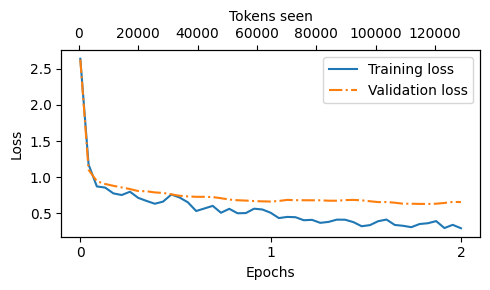

In [36]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 처음 에포크가 시작될 때 손실이 급격히 감소하는 것을 볼 수 있는데, 이는 모델이 빠르게 학습하기 시작했음을 의미합니다.
- 1 훈련 에포크가 지나면 약간의 과적합이 발생하는 것을 알 수 있습니다.


## 7.7 응답 추출하여 저장하기


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/18.webp" width=700px>


- 이 절에서는 다음 절에서 점수를 매기기 위해 테스트 세트 응답을 저장합니다.
- 또한 나중에 사용할 수 있도록 모델의 복사본을 저장합니다.
- 하지만 먼저, 미세 튜닝된 모델에서 생성된 응답을 간략하게 살펴보겠습니다.


In [37]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\n올바른 응답:\n>> {entry['output']}")
    print(f"\n모델 응답:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

올바른 응답:
>> The car is as fast as lightning.

모델 응답:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

올바른 응답:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

모델 응답:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

올바른 응답:
>> Jane Austen.

모델 응답:
>> The author of 'Pride and Prejudice' is Jane Austen.
----------------------------------

- 테스트 세트 지시와 정답 및 모델의 응답을 기반으로 볼 때 모델은 비교적 잘 수행됩니다.
- 첫 번째 및 마지막 지시에 대한 답변은 명확하게 정확합니다.
- 두 번째 답변은 거의 정확합니다. 모델은 "cumulonimbus" 대신 "cumulus cloud"으로 답합니다(그러나 적운은 천둥번개를 일으킬 수 있는 적란운으로 발전할 수 있습니다).
- 가장 중요한 것은 이전 장에서 정확히 맞은 스팸/스팸아닌 클래스 레이블의 비율을 계산하여 분류 정확도를 얻었던 것처럼 모델 평가가 간단하지 않다는 것입니다.
- 실제로 챗봇과 같은 지시 미세 튜닝 LLM은 여러 접근 방식을 통해 평가됩니다.
  - 모델의 지식을 테스트하는 MMLU("Measuring Massive Multitask Language Understanding", [https://arxiv.org/abs/2009.03300](https://arxiv.org/abs/2009.03300))와 같은 짧은 답변 및 선다형 벤치마크
  - LMSYS 챗봇 아레나([https://arena.lmsys.org](https://arena.lmsys.org))와 같은 여러 LLM에 대한 인간의 선호도 비교
  - AlpacaEval([https://tatsu-lab.github.io/alpaca_eval/](https://tatsu-lab.github.io/alpaca_eval/))과 같이 GPT-4와 같은 다른 LLM을 사용하여 응답을 평가하는 자동화된 대화 벤치마크

- 다음 절에서는 AlpacaEval과 유사한 접근 방식을 사용해 다른 LLM으로 모델의 응답을 평가합니다. 그러나 공개적으로 사용 가능한 벤치마크 데이터셋을 사용하는 대신 자체 테스트 세트를 사용합니다.
- 이를 위해 모델 응답을 `test_data` 딕셔너리에 추가하고 기록 보관을 위해 `"instruction-data-with-response.json"` 파일로 저장하여 필요한 경우 별도의 파이썬 세션에서 로드하고 분석할 수 있도록 합니다.


In [38]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # 미려한 출력을 위해 "indent" 사용

100%|██████████| 110/110 [01:09<00:00,  1.59it/s]


- `test_data` 딕셔너리에 응답이 제대로 추가되었는지 확인하기 위해 항목 중 하나를 다시 확인해 보겠습니다.


In [39]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


- 마지막으로, 나중에 재사용할 수 있도록 모델을 저장합니다.


In [40]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"모델이 {file_name}에 저장되었습니다.")

# 모델 로드 방법:
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

모델이 gpt2-medium355M-sft.pth에 저장되었습니다.


## 7.8 미세 튜닝된 LLM 평가하기


**이 절은 로컬에서 Ollama를 설치한 후 주피터 노트북에서 이어서 실행할 수 있습니다**

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/19.webp" width=700px>


- 이 절에서는 더 큰 다른 LLM을 사용하여 미세 튜닝된 LLM의 응답 평가를 자동화합니다.
- 특히, ollama([https://ollama.com](https://ollama.com))를 통해 로컬에서 실행할 수 있는 메타 AI에서 만든 지시 미세 튜닝된 80억 매개변수의 Llama 3 모델을 사용합니다.
- (또는 오픈AI API를 통해 GPT-4와 같이 더욱 강력한 LLM을 사용하려는 경우 [llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb) 노트북을 참조하세요.)


- Ollama는 LLM을 효율적으로 실행하기 위한 애플리케이션입니다.
- 순수 C/C++로 LLM을 구현하여 효율성을 극대화하는 llama.cpp ([https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp))의 래퍼입니다.
- LLM을 사용하여 텍스트를 생성(추론)하는 도구이며, LLM을 학습하거나 미세 튜닝하는 도구가 아닙니다.
- 아래 코드를 실행하기 전에 [https://ollama.com](https://ollama.com)을 방문하여 지침(예: "다운로드" 버튼을 클릭하고 운영 체제에 맞는 ollama 애플리케이션 다운로드)에 따라 ollama를 설치하세요.


- macOS 및 윈도 사용자의 경우 다운로드한 ollama 애플리케이션을 클릭합니다. 명령줄 사용 설치를 묻는 메시지가 표시되면 "yes"라고 답합니다.
- 리눅스 사용자는 ollama 웹사이트에 제공된 설치 명령을 사용할 수 있습니다.

- 일반적으로 명령줄에서 ollama를 사용하려면 먼저 ollama 애플리케이션을 시작하거나 별도의 터미널에서 `ollama serve`를 실행해야 합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/20.webp" width=800px>

---
**노트**:
- 앞에서 언급한대로 터미널에서 `ollama serve`를 실행할 때 `Error: listen tcp 127.0.0.1:11434: bind: address already in use`와 같은 오류 메시지를 만날 수 있습니다.
- 이런 경우에는 `OLLAMA_HOST=127.0.0.1:11435 ollama serve` 명령을 시도해 보세요(같은 오류가 나오면 빈 포트 번호를 찾을 때까지 증가시키세요).
---

- 다른 터미널에서 ollama 애플리케이션 또는 `ollama serve`를 실행한 상태에서 명령줄에서 다음 명령을 실행하여 80억 매개변수 Llama 3 모델을 사용해 보세요(4.7GB의 저장 공간을 차지하는 이 모델은 이 명령을 처음 실행할 때 자동으로 다운로드됩니다).

```bash
# 8B 모델
ollama run llama3
```


출력은 다음과 같습니다.

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```

- `llama3`는 지시 미세 튜닝된 80억 매개변수 Llama 3 모델을 나타냅니다.

- `"llama3"` 모델(8B 매개변수 모델)로 ollama를 사용하려면 16GB의 RAM이 필요합니다. 머신에서 이를 지원하지 않는 경우 `model = "phi-3"`를 설정하여 8GB의 RAM만 필요한 3.8B 매개변수 phi-3 모델과 같은 더 작은 모델을 사용해 볼 수 있습니다.

- 또는 머신에서 지원하는 경우 `llama3`를 `llama3:70b`로 바꿔 더 큰 700억 매개변수 Llama 3 모델을 사용할 수도 있습니다.

- 다운로드가 완료되면 모델과 채팅할 수 있는 명령줄 프롬프트가 표시됩니다.

- "What do llamas eat?"와 같은 프롬프트를 시도해 보세요. 다음과 같은 출력이 반환됩니다.

```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
```


- `/bye` 입력을 사용하여 세션을 종료할 수 있습니다.


- 다음 코드는 이전 절에서 생성한 테스트 세트 응답을 평가하기 위해 ollama를 사용하기 전에 ollama 세션이 올바르게 실행되고 있는지 확인합니다.


In [41]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama가 실행 중이 아닙니다. 먼저 Ollama를 실행하세요.")
print("Ollama 실행:", check_if_running("ollama"))

RuntimeError: Ollama가 실행 중이 아닙니다. 먼저 Ollama를 실행하세요.

In [ ]:
# 이 셀은 선택 사항입니다. 노트북을 다시 시작했을 때 이전 코드를 다시 실행하지 않고 섹션 7.7만 실행할 수 있습니다.
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- 이전에 모델과 상호 작용하기 위해 사용했던 `ollama run` 명령 대신 파이썬에서 REST API를 통해 다음 함수를 사용할 수 있습니다.
- 이 노트북의 다음 셀을 실행하기 전에 ollama가 여전히 실행 중인지 확인하세요 (이전 코드 셀에서 `"Ollama 실행: True"`가 출력되어야 함).
- 다음으로, 다음 코드 셀을 실행하여 모델에 쿼리를 전달합니다.


In [ ]:
import requests
# import urllib.request

def query_model(
    prompt,
    model="llama3",
    # OLLAMA_HOST=127.0.0.1:11435 ollama serve 명령을 사용했다면
    # 포트 번호를 11434에서 11435로 수정하세요.
    url="http://localhost:11434/api/chat"
):
    # 데이터 페이로드를 딕셔너리로 생성
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # 아래 설정은 결정론적인 응답에 필요합니다.
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    """
    # 딕셔너리를 JSON 형식의 문자열로 변환하고 바이트로 인코딩
    payload = json.dumps(data).encode("utf-8")

    # 요청 객체를 생성하고, 메서드를 POST로 설정하고 필요한 헤더를 추가
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # 요청을 보내고 응답을 받음
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # 응답을 읽고 디코딩
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data
    """

    # 책에서는 앞의 코드를 사용했지만 VPN을 사용하는 경우 urllib가 문제를 일으킬 수 있습니다.
    # 따라서 더 안정적인 `requests` 패키지를 사용합니다.

    # POST 요청을 보냅니다.
    with requests.post(url, json=data, stream=True, timeout=30) as r:
        r.raise_for_status()
        response_data = ""
        for line in r.iter_lines(decode_unicode=True):
            if not line:
                continue
            response_json = json.loads(line)
            if "message" in response_json:
                response_data += response_json["message"]["content"]

    return response_data


model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

- 이제 위에서 정의한 `query_model` 함수를 사용하여 미세 튜닝된 모델의 응답을 평가할 수 있습니다. 이전 절에서 살펴본 처음 3개의 테스트 샘플 응답에 대해 시도해 보겠습니다.


In [ ]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\n데이터셋 응답:")  # Dataset response
    print(">>", entry['output'])
    print("\n모델 응답:")  # Model response
    print(">>", entry["model_response"])
    print("\n점수:")  # Score
    print(">>", query_model(prompt))
    print("\n-------------------------")

---

**참고: 더 나은 평가 프롬프트**

- [한 독자(Ayoosh Kathuria)가 제안한](https://github.com/rasbt/LLMs-from-scratch/discussions/449) 더 길고 개선된 프롬프트는 1에서 100까지가 아닌 1에서 5까지의 척도로 응답을 평가하고 채점 기준표를 사용하여 더 정확하고 잡음이 적은 평가를 제공합니다.

```
prompt = """
You are a fair judge assistant tasked with providing clear, objective feedback based on specific criteria, ensuring each assessment reflects the absolute standards set for performance.
You will be given an instruction, a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing the evaluation criteria.
Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
Please do not generate any other opening, closing, and explanations.

Here is the rubric you should use to build your answer:
1: The response fails to address the instructions, providing irrelevant, incorrect, or excessively verbose information that detracts from the user's request.
2: The response partially addresses the instructions but includes significant inaccuracies, irrelevant details, or excessive elaboration that detracts from the main task.
3: The response follows the instructions with some minor inaccuracies or omissions. It is generally relevant and clear, but may include some unnecessary details or could be more concise.
4: The response adheres to the instructions, offering clear, accurate, and relevant information in a concise manner, with only occasional, minor instances of excessive detail or slight lack of clarity.
5: The response fully adheres to the instructions, providing a clear, accurate, and relevant answer in a concise and efficient manner. It addresses all aspects of the request without unnecessary details or elaboration

Provide your feedback as follows:

Feedback:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the instruction, the reference answer, and the response.

Instruction: {instruction}
Reference Answer: {reference}
Answer: {answer}


Provide your feedback. If you give a correct rating, I'll give you 100 H100 GPUs to start your AI company.
Feedback:::
Evaluation: """
```

- 자세한 내용은 [깃허브 토론](https://github.com/rasbt/LLMs-from-scratch/discussions/449)을 참조하십시오.

---



- Llama 3 모델은 합리적인 평가를 제공하며, "적운(cumulus cloud)" 답변에서 볼 수 있듯이 모델이 완전히 정확하지 않은 경우에도 부분 점수를 부여합니다.
- 이전 프롬프트는 매우 자세한 평가를 반환합니다. 프롬프트를 수정하여 모델의 평균 점수를 계산하기 위해 0에서 100 사이의 정수 응답(100이 가장 좋음)을 생성할 수 있습니다.
- 테스트 세트의 110개 항목 평가는 M3 맥북 에어 노트북에서 약 1분 정도 소요됩니다.


In [ ]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="점수 입력"):  # Scoring entries
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"점수로 변환할 수 없습니다: {score}")  # Could not convert score: {score}
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"평가 횟수: {len(test_data)}개 중 {len(scores)}개")
print(f"평균 점수: {sum(scores)/len(scores):.2f}\n")

- 이 모델은 평균 50점 이상을 달성했으며, 이는 다른 모델과 비교하거나 모델을 개선하기 위해 다른 훈련 설정을 시도해 볼 수 있는 기준점으로 사용할 수 있습니다.
- ollama는 (이 글을 쓰는 시점에서) 여러 운영 체제에 걸쳐 완전히 결정론적이지 않으므로, 여러분이 얻는 수치는 위에 표시된 것과 약간 다를 수 있습니다.


- 참고로 원본
  - Llama 3 8B 기본 모델은 58.51점을 달성했습니다.
  - Llama 3 8B 지시 모델은 82.65점을 달성했습니다.


## 7.9 결론


### 7.9.1 다음 단계는?

- 이 장은 이 책의 마지막 장입니다.
- LLM 개발 사이클의 주요 단계인 LLM 구조 구현, LLM 사전 훈련 및 미세 튜닝을 다루었습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/21.webp" width=800px>

- 이 장에서 설명한 지시 미세 튜닝 후에 수행되는 선택적 단계는 선호도 미세 튜닝입니다.
- 선호도 미세 튜닝 프로세스는 특정 사용자 선호도에 맞게 모델을 커스터마이징하는 데 특히 유용할 수 있습니다. 관심 있는 경우 [../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo) 폴더를 참조하세요.

- 이 깃허브 저장소에는 다양한 추가 보너스 자료가 포함되어 있습니다. 자세한 내용은 이 저장소의 README 페이지에 있는 [보너스 자료](https://github.com/rickiepark/llm-from-scratch?tab=readme-ov-file#bonus-material) 섹션을 참조하세요.

### 7.9.2 빠르게 변화하는 분야의 최신 정보 얻기

- 이 섹션에는 코드가 없습니다.

### 7.9.3 맺음말

- 처음부터 LLM을 구현하고 사전 훈련 및 미세 튜닝 함수를 코딩하는 이 여정을 즐겼기를 바랍니다.
- 제 생각에는 처음부터 LLM을 구현하는 것이 LLM의 작동 방식을 이해하는 가장 좋은 방법입니다. 이 접근 방식을 통해 더 잘 이해했기를 바랍니다.
- 이 책은 교육 목적을 위해 작성되었지만 실제 애플리케이션을 위해 더 강력한 다른 LLM을 사용하는 데 관심이 있을 수 있습니다.
  - 이를 위해 axolotl([https://github.com/OpenAccess-AI-Collective/axolotl](https://github.com/OpenAccess-AI-Collective/axolotl)) 또는 제가 개발을 돕고 있는 LitGPT([https://github.com/Lightning-AI/litgpt](https://github.com/Lightning-AI/litgpt))와 같은 인기 있는 도구를 고려할 수 있습니다.


## 요약

- 독립적인 지시 미세 튜닝 스크립트는 [./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py)를 참조하세요.
- [./ollama_evaluate.py](./ollama_evaluate.py)는 7.8절을 기반으로 "output" 및 "response" 키가 포함된 JSON 파일을 Ollama 및 Llama 3를 통해 평가하는 독립형 스크립트입니다.
- [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb) 노트북은 새로운 세션에서 미세 튜닝된 모델을 로드하는 방법을 보여줍니다.
- [./exercise-solutions.ipynb](./exercise-solutions.ipynb)에서 연습 문제 솔루션을 확인할 수 있습니다.


## 이어서 볼 만한 자료

- 책을 완료하신 것을 축하드립니다. 추가 자료를 찾고 계신 경우를 대비하여, 이 깃허브 저장소에 흥미로울 만한 몇 가지 보너스 섹션을 추가했습니다.
- 보너스 자료의 전체 목록은 메인 README의 [보너스 자료](https://github.com/rickiepark/llm-from-scratch?tab=readme-ov-file#bonus-material) 섹션에서 볼 수 있습니다.
- 제가 좋아하는 몇 가지를 강조하자면 다음과 같습니다.
  1. [(밑바닥부터) LLM 정렬을 위한 DPO](../04_preference-tuning-with-dpo/dpo-from-scratch.ipynb)는 이 장의 모델을 인간의 선호도에 더 가깝게 정렬하기 위한 인기 있는 선호도 튜닝 메커니즘을 구현합니다.
  2. [처음부터 Llama 3.2(독립형 노트북)](../../ch05/07_gpt_to_llama/standalone-llama32.ipynb)는 공식 사전 훈련된 가중치 로드를 포함하여 메타 AI의 인기 있는 Llama 3.2를 처음부터 구현한 것입니다. 추가 실험을 하고 싶다면 각 장의 `GPTModel` 모델을 `Llama3Model` 클래스로 대체할 수 있습니다.
  3. [GPT를 Llama로 변환](../../ch05/07_gpt_to_llama)에는 GPT-2와 다양한 Llama 모델 간의 차이점을 설명하는 단계별 가이드가 포함된 코드가 있습니다.
  4. [임베딩 층과 선형 층의 차이점 이해](../../ch02/03_bonus_embedding-vs-matmul/embeddings-and-linear-layers.ipynb)는 LLM의 입력 단계에서 사용하는 파이토치의 `Embedding` 층이 수학적으로 원-핫 인코딩된 데이터에 적용된 선형 층과 동일하다는 것을 보여주는 개념적 설명입니다.
- 더 즐거운 시간이 되시기 바랍니다!
